In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

from import_dataset import prepare_data
from constants import COUNTRY_CODES
import add_features

In [253]:
#df, df_countries = prepare_data()

from os.path import join
import pandas as pd

def prepare_data() -> tuple:
    
    df = pd.read_csv(join('data', 'TS.CF.N2.30yr.csv'))
    df_country = pd.read_csv(join('data', 'EMHIRESPV_TSh_CF_Country_19862015.csv'))

    # Create hourly DateTime column
    t = pd.date_range('1/1/1986', periods = len(df.index), freq = 'h')

    df['Hour'] = t
    df_country['Hour'] = t

    df = df.set_index('Hour')
    df_country = df_country.set_index('Hour')

    return df, df_country

df, df_country = prepare_data()

In [254]:
print(df.shape)
print(df_country.shape)

(262968, 255)
(262968, 29)


In [255]:
df = add_features.add_calendar_features(df)
df_country = add_features.add_calendar_features(df_country)

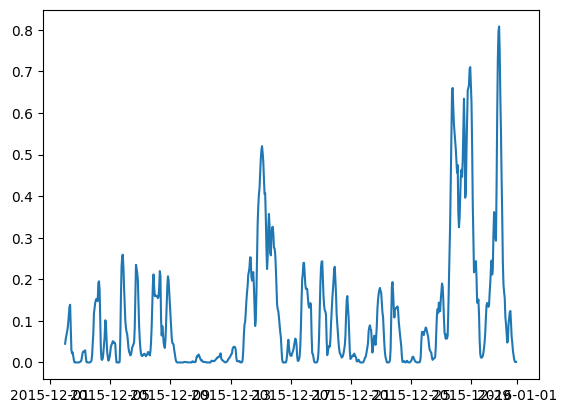

In [256]:
df_last_month = df[-(24*30):]
plt.plot(df_last_month.index, df_last_month['ES24'])

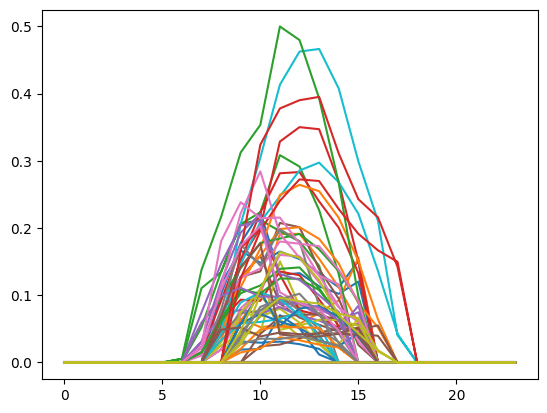

In [257]:
# First day of data
df_first_day_countries = df_country[['Hour'] + COUNTRY_CODES].iloc[:48, :]
df_first_day_countries = df_first_day_countries.set_index('Hour')
plt.plot(df_first_day_countries.index, df_first_day_countries)

In [258]:
# To start with I'll create a simple local model to forecast only the hour-ahead wind energy potential values for Belgium

# Get the last four years of data for belgium
df_be_last_four_years = df_country.loc[df_country['Year'].isin((2012, 2013, 2014, 2015)), 'BE']

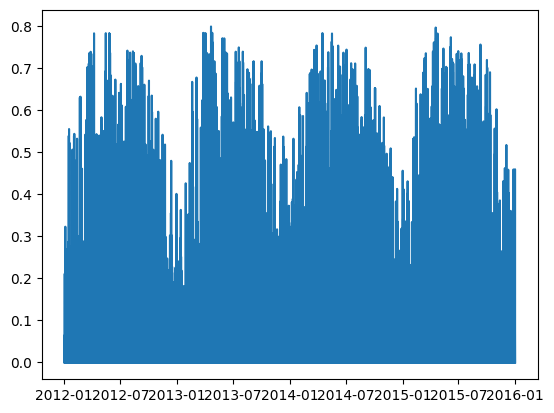

In [259]:
# Plotting the daily data over the two year period suggests there is daily, monthly and annual seasonality
plt.plot(df_be_last_four_years.index, df_be_last_four_years)

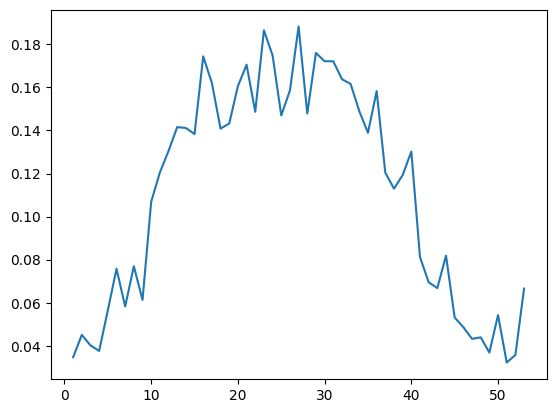

In [260]:
# Plot the weekly totals  for each week of the year over the last four years
df_weekly_totals = df_be_last_four_years.groupby(df_be_last_four_years.index.isocalendar().week).mean()
plt.plot(df_weekly_totals.index, df_weekly_totals)

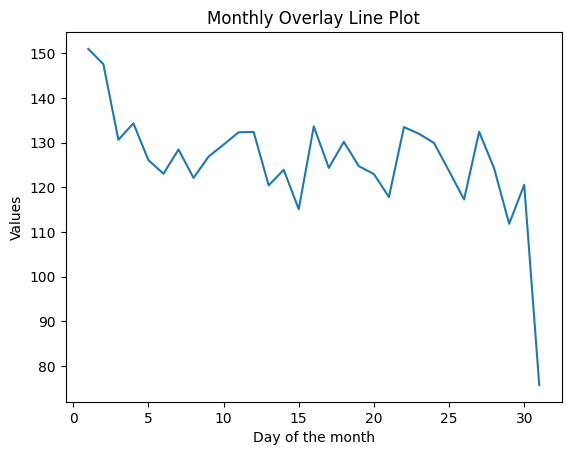

In [261]:
# Let't plot the daily values for each month overlayed to get a clearer picture of monthly seasonality
df_be_last_four_years_daily_tot = df_be_last_four_years.groupby(df_be_last_four_years.index.day).sum()
plt.plot(df_be_last_four_years_daily_tot.index, df_be_last_four_years_daily_tot)
plt.xlabel('Day of the month')
plt.ylabel('Values')
plt.title('Monthly Overlay Line Plot')
plt.show()

In [262]:
# It appears as though the monthly seasonality is less pronounced,
# with the drop on day 31 likely due to the shorter months causing the total to drop

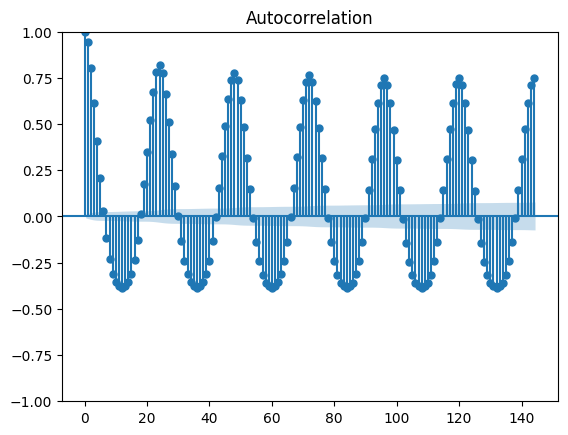

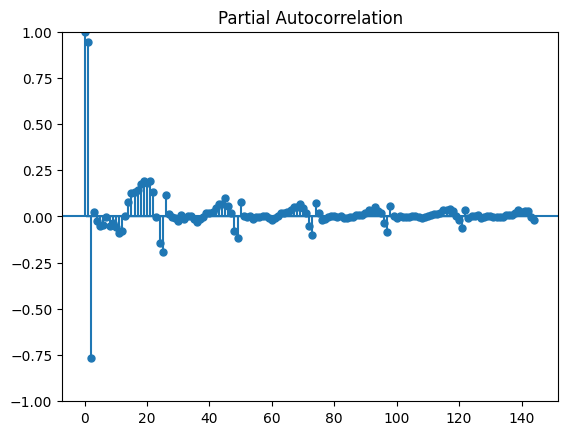

In [263]:
# Calculate the autocorrelation and plot a correlelogram for each hourly lag. This is unlikely to
# give us much useful information as the series is not stationary

# Calculate lag-n autocorrelation
lags = 24 * 7  # Number of hourly lags (for the past week)

'''autocorr_values = [df_be_last_four_years.autocorr(lag=lag) for lag in range(lags)]

print(autocorr_values)

# Create a correlogram
plt.figure(figsize=(8, 6))
plt.stem(range(lags), autocorr_values)#, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Hourly autocorrelation for the Past Week')
plt.grid(True)
plt.show()'''

# Plot ACF
sm.graphics.tsa.plot_acf(df_be_last_four_years.values.squeeze(), lags=48*3)
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df_be_last_four_years.values.squeeze(), lags=48*3, method="ywm")
plt.show()


In [264]:
import pandas as pd
import numpy as np

def add_calendar_features(df: pd.DataFrame, num_fourier_terms: int = 2) -> pd.DataFrame:
    """
    Adds discrete calendar features (ordinal step functions) and continuous Fourier terms to the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame with a datetime index.
        num_fourier_terms (int): Number of Fourier terms to add (default is 5).
    
    Returns:
        pd.DataFrame: DataFrame with added features.

    Example:
        If num_fourier_terms = 2, this will create sine and cosine wave features with
        wavelengths corresponding to one full cycle per day (i=1), and two full cycles
        per day (i=2).
    """
    
    # Add discrete calendar features (Essentially an ordinal step function)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['DayOfWeek'] = df.index.dayofweek
    df['Hour'] = df.index.hour

    # Add continuous calendar features (Continuous fourier terms)
    for i in range(1, num_fourier_terms + 1):
        freq = 2 * np.pi * i / 24  # Daily frequency (24 hours)
        df[f'Sin_{i}'] = np.sin(freq * df.index.hour)
        df[f'Cos_{i}'] = np.cos(freq * df.index.hour)

    return df

def add_time_lags(series: pd.Series, lags: int = 48) -> pd.DataFrame:

    df = pd.DataFrame()
    
    for i in range(1, lags + 1):
        df[f"Lagged_Potential_{i}h"] = series.shift(i)
        
    # Add target back
    df['Wind_Energy_Potential'] = series

    return df

def add_aggregations(df: pd.DataFrame) -> pd.DataFrame:

    # Add rolling window aggregations

    # Add seasonal rolling window aggregations

    # Add exponentially weighted moving averages

    #
    pass

In [265]:
# Time delay embedding

# Prepare the training set by adding lags, other temporal data and eventually some exogeneous featured
# to help the model learn more effectively. It seems like a few days' worth of hourly lags should
# suffice, whilst also keeping the number of features at a manageable level

df = add_time_lags(df_be_last_four_years)
df = add_calendar_features(df, num_fourier_terms=2)


In [266]:
df.tail()

,Lagged_Potential_1h,Lagged_Potential_2h,Lagged_Potential_3h,Lagged_Potential_4h,Lagged_Potential_5h,Lagged_Potential_6h,Lagged_Potential_7h,Lagged_Potential_8h,Lagged_Potential_9h,Lagged_Potential_10h,...,Wind_Energy_Potential,Year,Month,Week,DayOfWeek,Hour,Sin_1,Cos_1,Sin_2,Cos_2
Hour,,,,,,,,,,,,,,,,,,,,,
2015-12-31 19:00:00,0.0,0.0,0.0,0.075101,0.267779,0.404048,0.459439,0.433952,0.356473,0.251128,...,0.0,2015,12,53,3,19,-0.965926,0.258819,-0.500000,-8.660254e-01
2015-12-31 20:00:00,0.0,0.0,0.0,0.000000,0.075101,0.267779,0.404048,0.459439,0.433952,0.356473,...,0.0,2015,12,53,3,20,-0.866025,0.500000,-0.866025,-5.000000e-01
2015-12-31 21:00:00,0.0,0.0,0.0,0.000000,0.000000,0.075101,0.267779,0.404048,0.459439,0.433952,...,0.0,2015,12,53,3,21,-0.707107,0.707107,-1.000000,-4.286264e-16
2015-12-31 22:00:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.075101,0.267779,0.404048,0.459439,...,0.0,2015,12,53,3,22,-0.500000,0.866025,-0.866025,5.000000e-01
2015-12-31 23:00:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.075101,0.267779,0.404048,...,0.0,2015,12,53,3,23,-0.258819,0.965926,-0.500000,8.660254e-01


In [267]:
# Drop first rows with missing lag values
df = df.dropna()

In [268]:
# Split up the dataset. Just do simple 80:20 split for now

X = df.drop(columns=['Wind_Energy_Potential'])
y = df['Wind_Energy_Potential']

train_size = int(len(y) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

'''
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train and test model for this split
    ...
'''



(28012, 57)
(7004, 57)
(28012,)
(7004,)


'\n# Create a TimeSeriesSplit object\ntscv = TimeSeriesSplit(n_splits=5)\n\nfor train_index, test_index in tscv.split(X):\n    \n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    \n    # Train and test model for this split\n    ...\n'

In [274]:
'''# train a simple fully-connected neural network
from sklearn.neural_network import MLPRegressor

# the sklearn multilayer perceptron uses mse as the loss function and this can't be changed
reg = MLPRegressor(hidden_layer_sizes=(5, 5, 5), solver='adam', alpha=1e-5, random_state=1)
reg.fit(X_train, y_train)

# After training, you can predict labels for new samples
y_pred = reg.predict(X_test)

# Convert to series with same index as y_test
y_pred = pd.Series(y_pred, index=y_test.index)

residuals = y_pred - y_test
'''

In [279]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Train a simple fully connected nn in pytorch
class FFNN(nn.Module):

    def __init__(self, input_features: int):
        super(FFNN, self).__init__()
        self.hidden1 = nn.Linear(input_features, 5)
        self.hidden2 = nn.Linear(5, 5)
        self.hidden3 = nn.Linear(5, 5)
        self.output = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Feed input tensor x through the layers
        # Hidden layers use relu, output uses sigmoid activation
        # to constrain the outputs between 0 and 1 which is what
        # we need here
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.sigmoid(self.output(x))

        return x

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\Toby Usher\Documents\dev\wind_production_forecast\venv\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [275]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create data loader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Hour
2015-03-15 04:00:00   -0.039944
2015-03-15 05:00:00   -0.019069
2015-03-15 06:00:00    0.005310
2015-03-15 07:00:00    0.051069
2015-03-15 08:00:00    0.132001
                         ...   
2015-12-31 19:00:00   -0.059493
2015-12-31 20:00:00   -0.037498
2015-12-31 21:00:00   -0.032278
2015-12-31 22:00:00   -0.042530
2015-12-31 23:00:00   -0.053872
Length: 7004, dtype: float64

In [ ]:
# Initialise model, loss function and optimiser with an initial learning rate
model = FFNN(input_features=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
num_epochs = 100

for epoch in range(num_epochs):
    # Loop through all batches and train model
    for inputs, targets in train_loader:
        optimiser.zero_grad()
        
        # Feed inputs through model
        outputs = model(inputs)
        
        # Calculate loss and update weights
        loss = criterion(outputs, targets)
        loss.backwards()
        optimiser.step()
    
    # Print out model performance periodically
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model.eval()

# Turn off gradient tracking for inference (Prevents needless gradient
# computation, thus saving memory)
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    
    # Convert tensor back to numpy array
    y_pred = y_pred_tensor.numpy().flatten()

In [ ]:
# Convert predictions to a pandas Series with the same index as y_test
y_pred = pd.Series(y_pred, index=y_test.index)

# Calculate residuals
residuals = y_pred - y_test

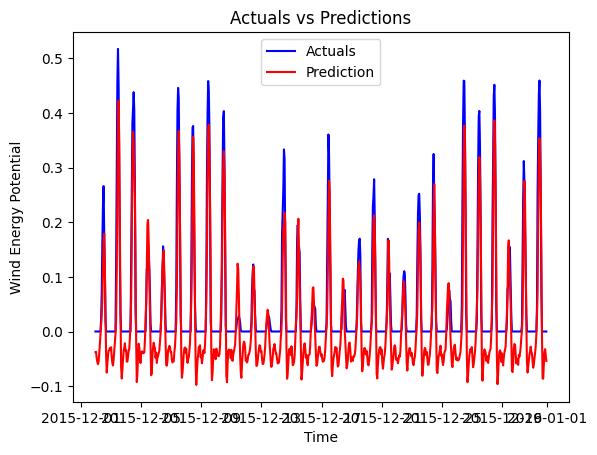

In [276]:
# Only want the last 30 days
end_date = df.index.max()
start_date = end_date - pd.Timedelta(days=30)

# Plot the target predictions against the actuals for the test set for the last month
plt.plot(y_test[start_date:end_date], label='Actuals', color='blue')
plt.plot(y_pred[start_date:end_date], label='Prediction', color='red')

plt.xlabel('Time')
plt.ylabel('Wind Energy Potential')
plt.title('Actuals vs Predictions')
plt.legend()

plt.show()

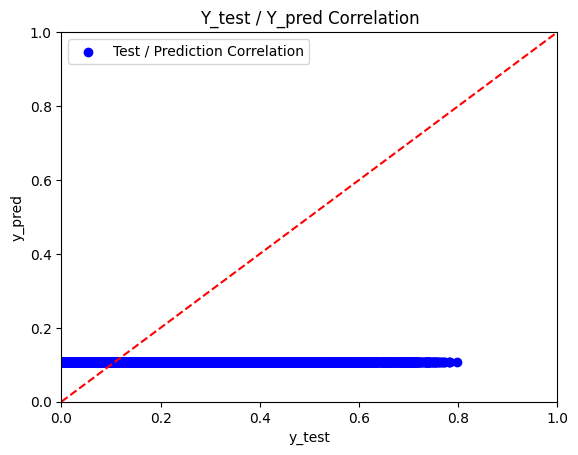

In [271]:
plt.scatter(y_test, y_pred, color='blue', label='Test / Prediction Correlation')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Set axes to start at 0
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Y_test / Y_pred Correlation')
plt.legend()

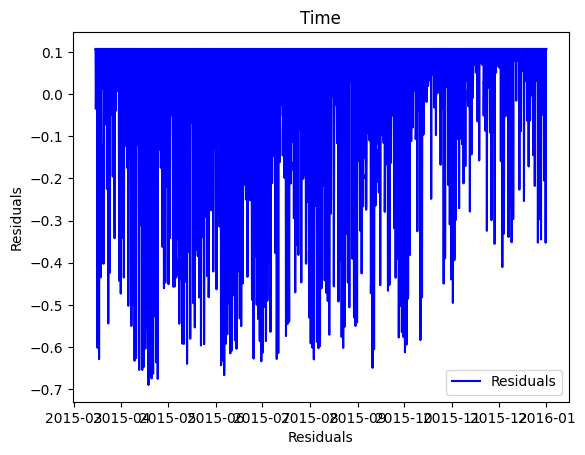

In [272]:
# Plot the residuals
# Plot the target predictions against the actuals for the test set for the last month
plt.plot(residuals, label='Residuals', color='blue')

plt.xlabel('Residuals')
plt.ylabel('Residuals')
plt.title('Time')
plt.legend()

plt.show()